In [2]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt

In [19]:
def gadecode(chrom, bits, x_lo, x_hi, y_lo, y_hi): # transform discrete chrom to number
    quant = 0.5**(np.arange(1,bits+1).reshape(bits,1))
    quant = quant / quant.sum()
    par_x = ((chrom[:,:bits].dot(quant))*(x_hi-x_lo)+x_lo)
    par_y = ((chrom[:,bits:].dot(quant))*(y_hi-y_lo)+y_lo)
    f= np.concatenate([par_x,par_y],axis=1)
    return f

In [20]:
def sort_by_cost(cost,par,pop):
    ind = np.argsort(cost)
    cost = np.take_along_axis(cost,ind,axis=0)
    par = par[ind]
    pop = pop[ind]
    return cost,par,pop

In [21]:
def select_maxProb(cost , pop_size,keep):
    M = math.ceil((pop_size - keep)/2)
    # roulette wheel
    prob = cost / cost.sum()
    odds = np.cumsum(prob)
    odds = np.insert(odds,0,0)
    while True:
        pick1 = np.random.rand(M)
        pick2 = np.random.rand(M)
        ic = 0
        #The index of parent
        ma, pa=[], []
        while ic < M:
            for id in range(len(cost)):
                if pick1[ic] <= odds[id+1] and pick1[ic] > odds[id]:
                    ma.append(id)
                if pick2[ic] <= odds[id+1] and pick2[ic] > odds[id]:
                    pa.append(id)
            ic+=1
        # check if it is identical index in ma or pa
        if (len(pa) == len(set(pa))) and (len(ma) == len(set(ma))):
            break
    
    return ma,pa

In [22]:
def crossover(pop,bits,ma,pa,crossrate):
    # do simple crossover
    xp = np.ceil(np.random.rand(1)*(bits-1)).astype(int)[0]
    tmp = pop.copy()
    for m,p in zip(ma,pa):
        if random.random() < crossrate:    
            tmp[m,:bits] = np.concatenate([pop[m,0:xp],pop[p,xp:bits]])
            tmp[p,:bits] = np.concatenate([pop[p,0:xp],pop[m,xp:bits]])
            tmp[m,bits:] = np.concatenate([pop[m,bits:bits+xp],pop[p,bits+xp:]])
            tmp[p,bits:] = np.concatenate([pop[p,bits:bits+xp],pop[m,bits+xp:]])
    pop = tmp
    return pop

In [23]:
def mutation(pop,pop_size,keep,mut_rate):
    M = math.ceil((pop_size - keep)/2)
    ma_prob = np.random.rand(M)
    pa_prob = np.random.rand(M)
    for i in range(M):
        if ma_prob[i] < mut_rate:
            location =math.ceil(random.random() * pop_size)- 1
            pop[ma[i],location] = abs(pop[ma[i],location] -1)
        if pa_prob[i] < mut_rate:
            location =math.ceil(random.random() * pop_size) - 1
            pop[pa[i],location] = abs(pop[pa[i],location] -1)
    return pop


In [24]:
def ObjectiveFF(x,y):
    ff = math.exp(-0.1*(x**4 + y**4)) + math.exp(math.cos(2*math.pi*x) +math.cos(2*math.pi*y))
    return ff

In [25]:
def handle1(par,total):
    con = par.sum(axis=1) > total
    off = par[con].sum(axis=1) - total
    tem = par[con]
    for i in range(len(par[con])):
        tem[i] = par[con][i] - off[i]
    par[con] = tem
    return par


In [26]:
def handle(par,total):
    # handle x+y constraint to constraint/2
    con = par.sum(axis=1) > total
    par[con] = total / 2
    return par

In [27]:
# Define parameters

npar = 2 #number of optimization variables (x,y)
mut_rate = 0.3 # mutation rate
selection = 0.5
crossrate = 0.6 # crossover rate

nbits = 8 # bits of chrom 

pop_size = nbits * npar  # population size

keep = int(math.floor(selection * pop_size))
Nt = int(nbits*npar)


Best solution 8.166798 at ( 0.02, 0.98)  in   0 iteration
Best solution 8.202054 at ( 0.01, 0.98)  in  33 iteration
Best solution 8.263683 at ( 0.98, 0.00)  in  38 iteration
Best solution 8.291651 at (-0.00,-1.00)  in 851 iteration
Best solution 8.333263 at ( 0.02, 0.00)  in 920 iteration
Best solution 8.348810 at ( 0.01,-0.01)  in 1420 iteration
Best solution 8.368905 at (-0.01, 0.00)  in 1733 iteration
Best solution 8.386814 at ( 0.00, 0.00)  in 7941 iteration


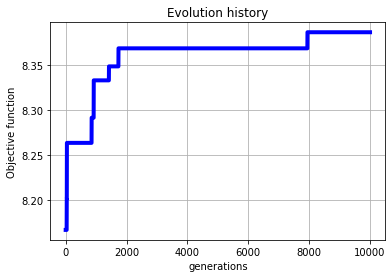

In [28]:
# init poulation of chrom
pop = np.around(np.random.rand(pop_size,Nt)).astype(int)
# number of generation
iteration = 10000
# init 
iga = 0
best = 0
best_record=[]
generation=[]
# given best solution of problem
solution = 8.3891

# start optimization
while( iga < iteration and round(best,3) != round(solution,3) ):
    par = gadecode(pop, nbits, -1, 1, -2, 1)

    par = handle(par,1)

    cost = np.array([ObjectiveFF(x,y) for x,y in par])

    cost,par,pop = sort_by_cost(cost,par,pop)
    maxc = cost.max()
    if maxc > best:
        x = par[-1][0]
        y = par[-1][1]
        best = maxc
        print("Best solution {:f} at ({:5.2f},{:5.2f})  in {:3d} iteration".format(best,x,y,iga))

    best_record.append(best)
    generation.append(iga+1)
    ma , pa = select_maxProb(cost , pop_size,keep)
    pop = crossover(pop,nbits,ma,pa,crossrate)
    pop = mutation(pop,pop_size,keep,mut_rate)
    iga +=1

# Plot evolution history
plt.plot(generation,best_record,'b-',linewidth=4)
plt.xlabel('generations')
plt.ylabel('Objective function')
plt.title('Evolution history')
plt.grid(True)
